# Practical 6: Temporal Difference Learning

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from IPython import display
import rldurham as rld
from rldurham import plot_frozenlake as plot

In [2]:
name = 'FrozenLake-v1'
env = rld.make(name, is_slippery=False)                 # 4x4
env = rld.make(name, map_name="8x8", is_slippery=False) # 8x8
# env = rld.make(name, desc=["SFHH",
#                            "HFFH",
#                            "HHFF",
#                            "HHHG",], is_slippery=False) # custom
rld.seed_everything(42, env)
# LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

Seed set to 42


(42, 0, {'prob': 1})

You can use this helper class to define epsilon-greed policies based on $Q$-values

In [3]:
class QPolicy:
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def sample(self, state):
        return np.random.choice(np.arange(self.Q.shape[1]), p=self[state])
        if np.random.rand() > self.epsilon:
            best_actions = np.argwhere(self.Q[state]==np.max(self.Q[state])).flatten()
            return np.random.choice(best_actions)
        else:
            return env.action_space.sample()

    def __getitem__(self, state):
        Qs = self.Q[state]
        p = np.zeros_like(Qs)
        max_actions = np.argwhere(Qs == Qs.max())
        p[max_actions] = 1 / len(max_actions)
        return (1 - self.epsilon) * p + self.epsilon / len(p)

We can keep some plotting data in these variables (re-evaluate the cell to clear data)

In [4]:
reward_list = [[]]
auc = [0]
test_reward_list = [[]]
test_auc = [0]
plot_data = [[]]
plot_labels = []
experiment_id = 0

and use these functions to update and plot the learning progress

In [5]:
# (using global variables in functions)
def update_plot(mod):
    reward_list[experiment_id].append(reward_sum)
    auc[experiment_id] += reward_sum
    test_reward_list[experiment_id].append(test_reward_sum)
    test_auc[experiment_id] += test_reward_sum
    if episode % mod == 0:
        plot_data[experiment_id].append([episode,
                                         np.array(reward_list[experiment_id]).mean(),
                                         np.array(test_reward_list[experiment_id]).mean()])
        reward_list[experiment_id] = []
        test_reward_list[experiment_id] = []
        for i in range(len(plot_data)):
            lines = plt.plot([x[0] for x in plot_data[i]],
                             [x[1] for x in plot_data[i]], '-', 
                             label=f"{plot_labels[i]}, AUC: {auc[i]}|{test_auc[i]}")
            color = lines[0].get_color()
            plt.plot([x[0] for x in plot_data[i]],
                     [x[2] for x in plot_data[i]], '--', color=color)
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.legend()
        display.clear_output(wait=True)
        plt.show()
        
def next_experiment():
    reward_list.append([])
    auc.append(0)
    test_reward_list.append([])
    test_auc.append(0)
    plot_data.append([])
    return experiment_id + 1

## On-policy (SARSA) and off-policy (Q-Learning) with TD(0)

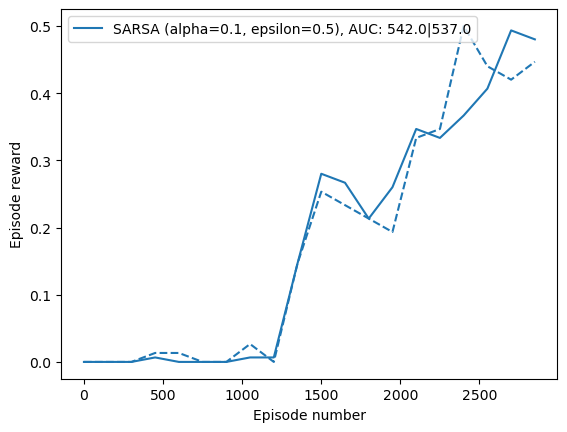

Sampling policy and values


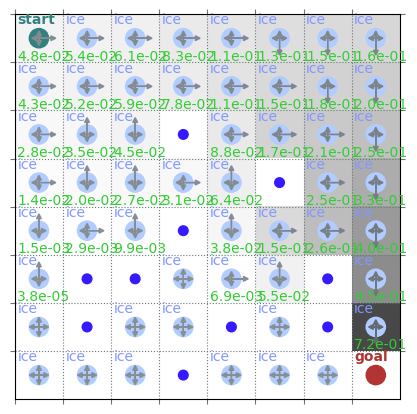

Learned policy and optimal/max values


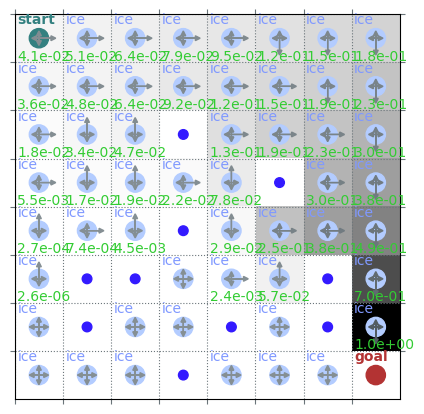

In [6]:
# parameters
num_episodes = 3000
alpha = 0.1
gamma = 0.9
epsilon = 0.5
on_policy = True # SARSA or Q-Learning

# value initialisation
Q = np.random.uniform(0, 1e-5, [env.observation_space.n, env.action_space.n]) # noisy
Q = np.zeros([env.observation_space.n, env.action_space.n])                   # neutral
V = np.zeros([env.observation_space.n])

if on_policy:
    # policies for SARSA
    # vvvvvvvvvvvvvvvvvv
    sample_policy = QPolicy(Q, epsilon)
    learned_policy = sample_policy
    plot_labels.append(f"SARSA (alpha={alpha}, epsilon={epsilon})")
    # ^^^^^^^^^^^^^^^^^^
else:
    # policies for Q-Learning
    # vvvvvvvvvvvvvvvvvvvvvvv
    sample_policy = QPolicy(Q, epsilon)
    td_epsilon = 0.01
    learned_policy = QPolicy(Q, td_epsilon)
    plot_labels.append(f"Q-Learning (alpha={alpha}, epsilon={epsilon}|{td_epsilon})")
    # ^^^^^^^^^^^^^^^^^^^^^^^

for episode in range(num_episodes):
    state, _ = env.reset()
    reward_sum = 0
    # learning a policy
    for t in itertools.count():
        action = sample_policy.sample(state)
        next_state, reward, term, trun, _ = env.step(action)
        done = term or trun
        next_action = learned_policy.sample(next_state)
        
        # TD(0) targets
        # vvvvvvvvvvvvv
        v_target = reward + gamma * V[next_state]
        q_target = reward + gamma * Q[next_state, next_action]
        # ^^^^^^^^^^^^^
        
        # expected TD(0) target
        # vvvvvvvvvvvvv
        expected_Q = (learned_policy[next_state] * Q[next_state]).sum()
        q_target = reward + gamma * expected_Q
        # ^^^^^^^^^^^^^
        
        # updates
        # vvvvvvvvvvvvv
        s, a = state, action
        V[s] += alpha * (v_target - V[s])
        Q[s, a] += alpha * (q_target - Q[s, a])
        # ^^^^^^^^^^^^^

        reward_sum += reward
        if done:
            break
        state = next_state

    # testing the learned policy
    state, _ = env.reset()
    test_reward_sum = 0
    while True:
        action = learned_policy.sample(state)
        next_state, reward, term, trun, _ = env.step(action)
        done = term or trun
        test_reward_sum += reward
        state = next_state
        if done:
            break

    update_plot(int(np.ceil(num_episodes / 20)))

experiment_id = next_experiment()
print("Sampling policy and values")
plot(env, v=V, policy=sample_policy, draw_vals=True)
print("Learned policy and optimal/max values")
plot(env, v=Q.max(axis=1), policy=learned_policy, draw_vals=True)

## Multi-Step Targets with TD(n)

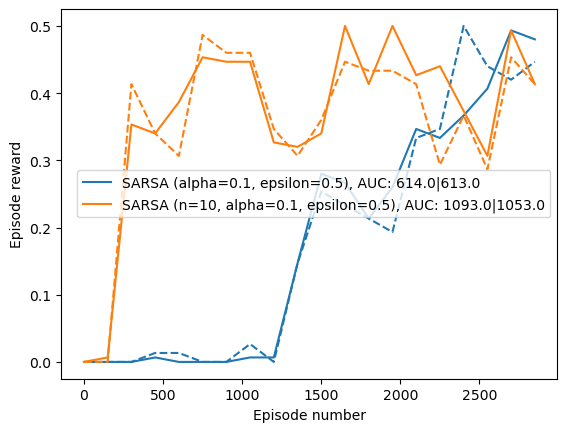

Sampling policy and values


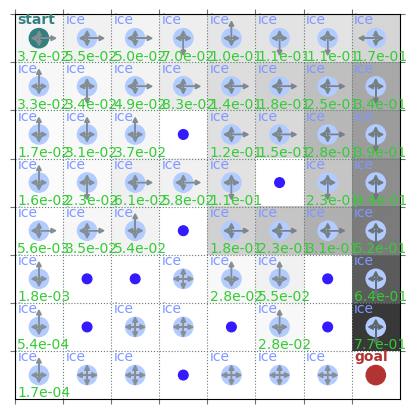

Learned policy and optimal/max values


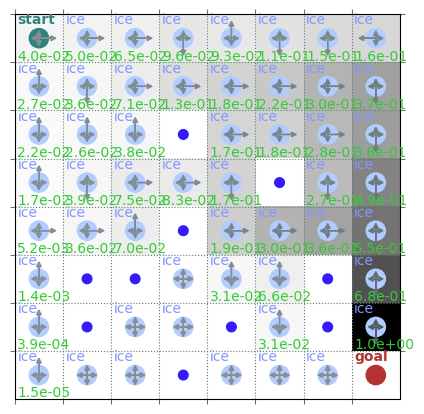

In [7]:
# parameters
num_episodes = 3000
alpha = 0.1
gamma = 0.9
epsilon = 0.5
on_policy = True  # SARSA or Q-Learning
n = 10            # length of trace to use

# value initialisation
Q = np.random.uniform(0, 1e-5, [env.observation_space.n, env.action_space.n]) # noisy
Q = np.zeros([env.observation_space.n, env.action_space.n])                   # neutral
V = np.zeros([env.observation_space.n])

if on_policy:
    # policies for SARSA
    # vvvvvvvvvvvvvvvvvv
    sample_policy = QPolicy(Q, epsilon)
    learned_policy = sample_policy
    plot_labels.append(f"SARSA (n={n}, alpha={alpha}, epsilon={epsilon})")
    # ^^^^^^^^^^^^^^^^^^
else:
    # policies for Q-Learning
    # vvvvvvvvvvvvvvvvvvvvvvv
    sample_policy = QPolicy(Q, epsilon)
    td_epsilon = 0.01
    learned_policy = QPolicy(Q, td_epsilon)
    plot_labels.append(f"Q-Learning (n={n}, alpha={alpha}, epsilon={epsilon}|{td_epsilon})")
    # ^^^^^^^^^^^^^^^^^^^^^^^

for episode in range(num_episodes):
    state, _ = env.reset()
    reward_sum = 0
    done_n = 0

    # trace of the last n + 1 transitions (state, action, reward, next_action)
    trace = np.zeros((n + 1, 4), dtype=int) 

    # learning a policy
    for t in itertools.count():
        action = sample_policy.sample(state)
        next_state, reward, term, trun, _ = env.step(action)
        done = term or trun
        next_action = learned_policy.sample(next_state)

        # remember transitions (incl. next action sampled by learned policy)
        trace[-1] = (state, action, reward, next_action)

        # start computing updates if trace is long enough
        if t > n:

            # n-step targets
            # vvvvvvvvvvvvvv
            n_step_return = sum(gamma ** i * r for i, (_, _, r, _) in enumerate(trace))
            v_target = n_step_return + gamma ** (n + 1) * V[next_state]
            q_target = n_step_return + gamma ** (n + 1) * Q[next_state, next_action]
            # ^^^^^^^^^^^^^^

            # importance sampling factor for TD(n) Q-Learning
            if on_policy:
                rho = 1
            else:
                # vvvvvvvvvvvvvvvvvvvvvvvvvv
                rho = np.prod([learned_policy[s][a] / sample_policy[s][a] for s, a, _, _ in trace])
                # ^^^^^^^^^^^^^^^^^^^^^^^^^^

            # updates
            # vvvvvvv
            s, a, _, _ = trace[0]
            V[s] += alpha * rho * (v_target - V[s])
            Q[s, a] += alpha * rho * (q_target - Q[s, a])
            # ^^^^^^^

        reward_sum += reward
        state = next_state

        # roll trace to make space for next transition at the end
        trace = np.roll(trace, shift=-1, axis=0)

        # fill with dummy transitions so we can learn from end of episode
        done_n += done
        if done_n > n:
            break

    # testing the learned policy
    state, _ = env.reset()
    test_reward_sum = 0
    while True:
        action = learned_policy.sample(state)
        next_state, reward, term, trun, _ = env.step(action)
        done = term or trun
        test_reward_sum += reward
        state = next_state
        if done:
            break

    update_plot(int(np.ceil(num_episodes / 20)))

experiment_id = next_experiment()
print("Sampling policy and values")
plot(env, v=V, policy=sample_policy, draw_vals=True)
print("Learned policy and optimal/max values")
plot(env, v=Q.max(axis=1), policy=learned_policy, draw_vals=True)